In [ ]:
# Step 1: Import Library
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import numpy as np
import os
import matplotlib.pyplot as plt

# Step 2: Define Hyperparameters
train_path = '/Users/aqsal/Downloads/FINALPROJECT/finpro-fraud/p2-final-project-signature-detector/dataset/dataset2/processed_train'
test_path = '/Users/aqsal/Downloads/FINALPROJECT/finpro-fraud/p2-final-project-signature-detector/dataset/dataset2/processed_test'

img_height = 224  # Ukuran gambar
img_width = 224  # Ukuran gambar
batch_size = 16  # Jumlah sampel per batch

# Step 3: Data Augmentation dan Data Generator
train_datagen = ImageDataGenerator(rescale=1./255., validation_split=0.4)

train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(img_height, img_width),
                                              class_mode='sparse',
                                              subset='training',
                                              batch_size=batch_size,
                                              shuffle=True,
                                              seed=10)

val_set = train_datagen.flow_from_directory(train_path,
                                            target_size=(img_height, img_width),
                                            class_mode='sparse',
                                            subset='validation',
                                            batch_size=batch_size,
                                            shuffle=True,
                                            seed=10)

test_datagen = ImageDataGenerator(rescale=1./255.)
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(img_height, img_width),
                                            class_mode='sparse',
                                            batch_size=batch_size,
                                            shuffle=False,
                                            seed=10)

# Step 4: Load Pretrained MobileNetV2
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

# Freeze layer pretrained
base_model.trainable = False

# Step 5: Tambahkan Fully Connected Layers
modelmobile = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(train_set.class_indices), activation='softmax')
])

# Step 6: Compile Model
modelmobile.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Step 7: Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Step 8: Training Model
historymobilenet = modelmobile.fit(
    train_set,
    validation_data=val_set,
    epochs=150,  # Mulai dengan 150 epoch, bisa dihentikan lebih awal dengan EarlyStopping
    batch_size=batch_size,
    callbacks=[early_stopping]
)

Found 864 images belonging to 32 classes.
Found 544 images belonging to 32 classes.
Found 693 images belonging to 32 classes.
Epoch 1/150


/Users/aqsal/miniforge3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


54/54 ━━━━━━━━━━━━━━━━━━━━ 14s 228ms/step - accuracy: 0.0546 - loss: 3.8296 - val_accuracy: 0.3180 - val_loss: 2.8780
Epoch 2/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.1581 - loss: 3.0492 - val_accuracy: 0.7004 - val_loss: 2.3412
Epoch 3/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 196ms/step - accuracy: 0.3262 - loss: 2.5754 - val_accuracy: 0.7960 - val_loss: 1.8570
Epoch 4/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 209ms/step - accuracy: 0.4298 - loss: 2.3173 - val_accuracy: 0.8971 - val_loss: 1.4420
Epoch 5/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.5299 - loss: 1.9644 - val_accuracy: 0.9669 - val_loss: 1.0841
Epoch 6/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step - accuracy: 0.6425 - loss: 1.6271 - val_accuracy: 0.9779 - val_loss: 0.7995
Epoch 7/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 233ms/step - accuracy: 0.6961 - loss: 1.3667 - val_accuracy: 0.9816 - val_loss: 0.6028
Epoch 8/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 195ms/step - accuracy: 0.7450 - loss: 1.1728 - val_accuracy

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.8328 - loss: 0.6392
Test Loss: 0.8931
Test Accuracy: 0.7858


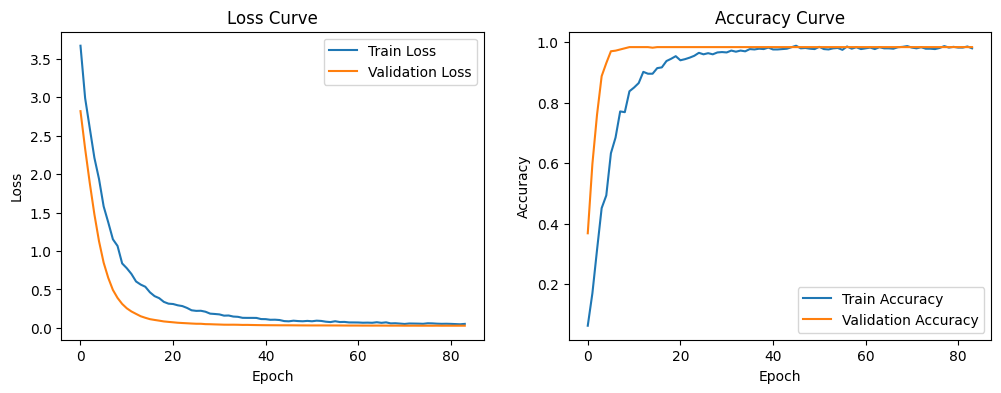

In [ ]:
# Step 9: Evaluasi Model
test_loss, test_accuracy = modelmobile.evaluate(test_set)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Step 10: Visualisasi Hasil Training
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(historymobilenet.history['loss'], label='Train Loss')
plt.plot(historymobilenet.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(historymobilenet.history['accuracy'], label='Train Accuracy')
plt.plot(historymobilenet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

In [ ]:
# Step 11: Classification Report dan Confusion Matrix
#import Machine Learning
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


y_true = test_set.classes
y_pred = modelmobile.predict(test_set)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(test_set.class_indices.keys())))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step
Classification Report:
                           precision    recall  f1-score   support

             Affan Haidar       1.00      1.00      1.00        22
              Ainun Putri       0.76      1.00      0.86        22
          Andi ahmad afiq       1.00      0.95      0.98        22
    Andi. Dwi Yuniarti. H       0.56      0.64      0.60        22
                 Bayu Adi       0.76      0.86      0.81        22
       Dewi Titania Randa       0.69      1.00      0.81        11
           Dinda unidayan       0.88      0.95      0.91        22
              Dwi Octavia       0.89      0.73      0.80        22
                    Fadli       0.67      0.27      0.39        22
        Fildzah Khalishah       1.00      0.68      0.81        22
           Fiqram Faathir       0.96      1.00      0.98        22
                    Githa       1.00      0.50      0.67        22
         Hashimatul Zaria       1.00      0.95      0.98        

In [ ]:
# frezz parameter untuk tidak di edit lagi parameter model nya terhadap train.fit
# freeze params

modelmobile.trainable = False
modelmobile.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         7,710 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,264,924 (12.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,593,630 (9.89 MB)

 Optimizer params: 671,294 (2.56 MB)

In [ ]:
# Step 13: Simpan Model
modelmobile.save("mobilenet_signature_modelnewsegmenlagi.h5")
print("Model disimpan sebagai mobilenet_signature_modeladd.h5")

# Step 14: Prediksi Tanda Tangan Baru
def predict_signature(image_path, model, class_indices):
    """
    Melakukan prediksi terhadap gambar tanda tangan baru.
    """
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    class_label = list(class_indices.keys())[predicted_class]
    
    print(f"Prediksi: {class_label}")
    return class_label

Model disimpan sebagai mobilenet_signature_modeladd.h5


In [ ]:
from tensorflow.keras.preprocessing import image


def predict_image_path(image_url, modelmobile, train_set):
    try:
        # Load gambar & konversi ke RGB
        img = Image.open(image_url).convert("RGB")  # **Convert ke RGB**
        img = img.resize((224, 224))  # Sesuaikan dengan input model
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # Normalisasi

        # Prediksi dengan model
        prediction = modelmobile.predict(img_array)
        predicted_class = np.argmax(prediction[0])
        confidence = prediction[0][predicted_class] * 100

        # Ambil nama kelas dari dataset
        class_labels = list(train_set.class_indices.keys())
        predicted_label = class_labels[predicted_class]

        return f"Predicted class: {predicted_label}, Confidence: {confidence:.2f}%"

    except Exception as e:
        return f"Error during prediction: {e}"

# Contoh pemanggilan fungsi
image_url = "/Users/aqsal/Downloads/FINALPROJECT/tryjpg/dataset2/test/Fildzah Khalishah/Fildzah Khalishah_60.png"  # Ganti dengan path gambar lokal
result = predict_image_path(image_url, modelmobile, train_set)
print(result)

Error during prediction: name 'Image' is not defined


In [ ]:
# Show labels

print(train_set.class_indices)
print(test_set.class_indices)

{'Affan Haidar': 0, 'Ainun Putri': 1, 'Andi ahmad afiq': 2, 'Andi. Dwi Yuniarti. H': 3, 'Bayu Adi': 4, 'Dewi Titania Randa': 5, 'Dinda unidayan': 6, 'Dwi Octavia': 7, 'Fadli': 8, 'Fildzah Khalishah': 9, 'Fiqram Faathir': 10, 'Githa': 11, 'Hashimatul Zaria': 12, 'Ikbal': 13, 'Ishaq usn': 14, 'Khairunnisa': 15, 'Laode Sandi Yunus': 16, 'Lithania': 17, 'Mariati unidayan': 18, 'Mas Bilal': 19, 'Muh Luthfi': 20, 'Muh. Falah Mubaraq': 21, 'Muhammad Azriel Saktiawan': 22, 'Mursawal': 23, 'Ni Luh Ica Ardini': 24, 'Ni Made Sri Ulandari': 25, 'Nur Ilmi Fadilah': 26, 'Prety Maharani Utami': 27, 'Putri Angraini Aziz': 28, 'Putu Riva': 29}
{'Affan Haidar': 0, 'Ainun Putri': 1, 'Andi ahmad afiq': 2, 'Andi. Dwi Yuniarti. H': 3, 'Bayu Adi': 4, 'Dewi Titania Randa': 5, 'Dinda unidayan': 6, 'Dwi Octavia': 7, 'Fadli': 8, 'Fildzah Khalishah': 9, 'Fiqram Faathir': 10, 'Githa': 11, 'Hashimatul Zaria': 12, 'Ikbal': 13, 'Ishaq usn': 14, 'Khairunnisa': 15, 'Laode Sandi Yunus': 16, 'Lithania': 17, 'Mariati unid